In [55]:
# Data

In [56]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [57]:
# Dataset

train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
len(train_dataset)

60000

In [58]:
tmp_img, tp_label = train_dataset[0]
tmp_img.shape, tp_label

(torch.Size([1, 28, 28]), 9)

In [59]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

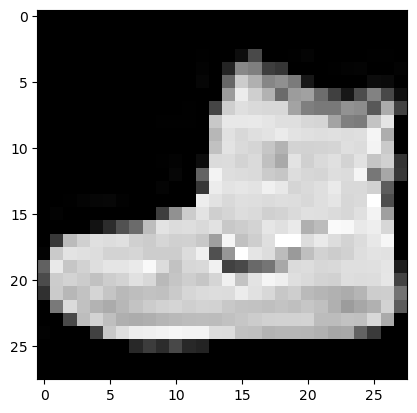

In [60]:
import matplotlib.pyplot as plt
plt.imshow(tmp_img.squeeze(), cmap="gray")

In [61]:
# TRain / test splt

from torch.utils.data import random_split
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])
len(train_dataset), len(val_dataset)

(50000, 10000)

In [62]:
# Dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64)  # Random
val_loader = DataLoader(dataset=val_dataset, batch_size=64)

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1)

In [64]:
# Model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.conv = nn.Sequential(
            # Input : 64 * 1 * 28 * 28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3), # 32个features, 自己定义的, dim = 26 * 26
            # Out = 64(b) * 32 * 26 * 26
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),    # 64 * 1 * 28 * 28 -> 64 * 748
            nn.Linear(32 * 26 * 26, 50),    # 28*28
            # nn.ReLU(),
            nn.Linear(50, 10),
            )
        
    def forward(self, x):
        out = self.conv(x)
        out = self.fc(out) # <<< dont forget this
        return out 
    

tmp_model = MyModel().to(device)
tmp_batch, _ = next(iter(train_loader))
tmp_out = tmp_model(tmp_batch)
tmp_out.shape


torch.Size([64, 10])

In [65]:
# Model training

In [66]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [67]:
loss_fn = nn.CrossEntropyLoss()

In [68]:
model = MyModel().to(device)

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 1e-1
n_epochs = 2

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch)
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val)
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")


Epoch: 0 | Loss: 0.54857, Accuracy: 80.21% | val loss: 0.44761, val acc: 83.55%
Epoch: 1 | Loss: 0.36122, Accuracy: 87.09% | val loss: 0.38194, val acc: 85.90%


In [69]:
# Prediction / Evaluation

In [70]:
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
len(test_dataset)

10000

In [71]:
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

In [74]:
model.eval()
test_acc = 0

with torch.no_grad():
    for x_val, y_val in val_loader:

        x_val = x_val.to(device)
        y_val = y_val.to(device)

        y_logits = model(x_val)
    
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        test_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
    
test_acc /= len(test_loader)

test_acc

85.89769108280255